In [1]:
from statsmodels.stats.descriptivestats import sign_test
import matplotlib.pyplot as plt
from scipy import stats
import datetime as dt
import pandas as pd
import numpy as np
import scipy

In [2]:
df = pd.read_csv('сомоизоляция_по_часам.csv', sep=';')

### Первичный анализ данных
**Данные пердставляют из себя индекс самоизоляции в Москве по часам с 23.02.2020 по 4.30.2020**

ссылка на обновляемый датасет: https://datalens.yandex.ru/dashboards/zji26r1j55rev?tab=Lk

*Индекс самоизоляции – это интегрированный показатель, рассчитанный на данных об использовании различных приложений и сервисов Яндекса*

**В датасете присутствуют три поля: город, дата и время записи индекса и сам индекс со шкалой от 0 до 5**

Чем выше значение, тем лучше: 0 – 2.9 балла на улице очень много людей, 3 – 3.9 балла на улице много людей, 4 – 5 баллов на улице почти никого

**Цель проекта: проанализировать данные используя визуализацию и статистические критерии, построить предсказание временного ряда**

In [3]:
df.head(3)

,Город,Дата и время местное,Индекс
0,Петропавловск-Камчатский,01.05.2020 02:00:00,4.6
1,Петропавловск-Камчатский,01.05.2020 01:00:00,4.5
2,Южно-Сахалинск,01.05.2020 01:00:00,4.5


### Предобработка данных
**На этом этапе я удаляю из датасета все города кроме Москвы и в качестве индекса беру дату и время записи соответствующего индекса**

**Также добаляю новый столбец, характерезующий день недели и столбец, являющийся флагом наличия выходного в данный день**

**В Москве 30 марта ввели режим самоизоляции, 15 апреля произошло ужесточение(введение пропускного режима) это также отобразим в нашем датасете**

In [4]:
df = df[df['Город'] == 'Москва']
df.drop(['Город'], axis=1, inplace=True)
df.rename(columns={'Дата и время местное':'Datetime', 'Индекс':'Index'}, inplace=True)

In [5]:
df['Datetime'] = pd.to_datetime(df.Datetime,format='%d.%m.%Y %H:%M:%S') 
df.sort_values('Datetime',axis = 0,inplace=True)
df.index = df.Datetime
df.drop('Datetime', axis = 1, inplace = True)

In [6]:
df['key'] = 1
df['month'] = df.index.month
df['date'] = df.index.day
df['hour'] = df.index.hour

In [7]:
df['day_of_week'] = df.index.dayofweek
df['weekend'] = 0
filters = df.index.dayofweek > 4
df.loc[filters, 'weekend'] = 1

In [8]:
df['quarantine'] = 0
df.loc['2020-03-30':'2020-04-14', 'quarantine'] = 1
df.loc['2020-04-15':,'quarantine'] = 2

In [9]:
print(df.shape)
df.head(3)

(1626, 8)


,Index,key,month,date,hour,day_of_week,weekend,quarantine
Datetime,,,,,,,,
2020-02-23 00:00:00,4.2,1,2,23,0,6,1,0
2020-02-23 01:00:00,4.4,1,2,23,1,6,1,0
2020-02-23 02:00:00,4.5,1,2,23,2,6,1,0


### Визуальный анализ данных

**На этих графиках мы видим, что индекс самоизоляции примерно с 15 марта начал плавно расти (некоторые люди уже в это время решили по возможности самоизолироваться, также внесло вклад то, что с 16 марта начали закрывать места массового скопления людей: парки, кинотеатры и тд, университеты начали переводить студентов на удаленное обучение), 30 марта ввели режим обязательной самоизоляции и индекс резко вырос**

**Заметно, что в буднии дни по сравнению с выходными максимальные показатели индекса больше, а минимальные меньше (днем больше людей выходят на улицу, но ночью они остаются дома), причем пики среднего за день индекса приходятся на воскресенья, также из будних дней выделяются 24 февраля и 9 марта это были праздничные дни (переведем их в категорию выходные)**

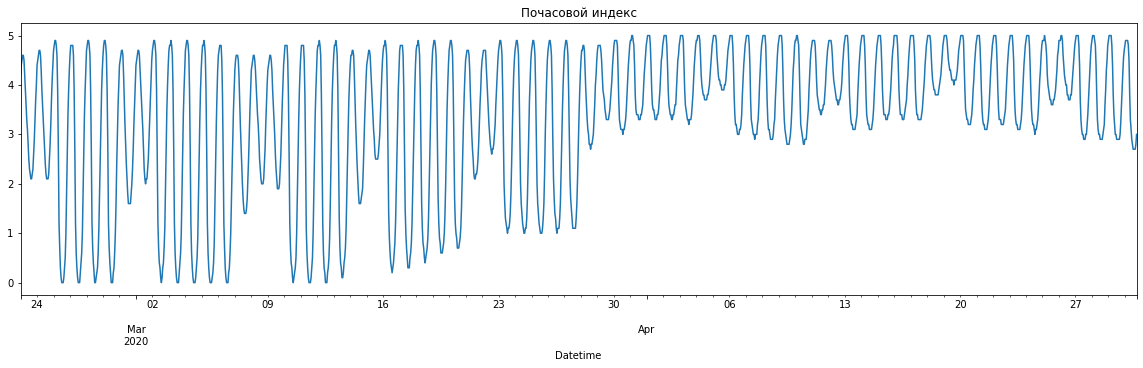

In [10]:
df['Index'].plot(figsize=(20, 5), title='Почасовой индекс')
plt.show()

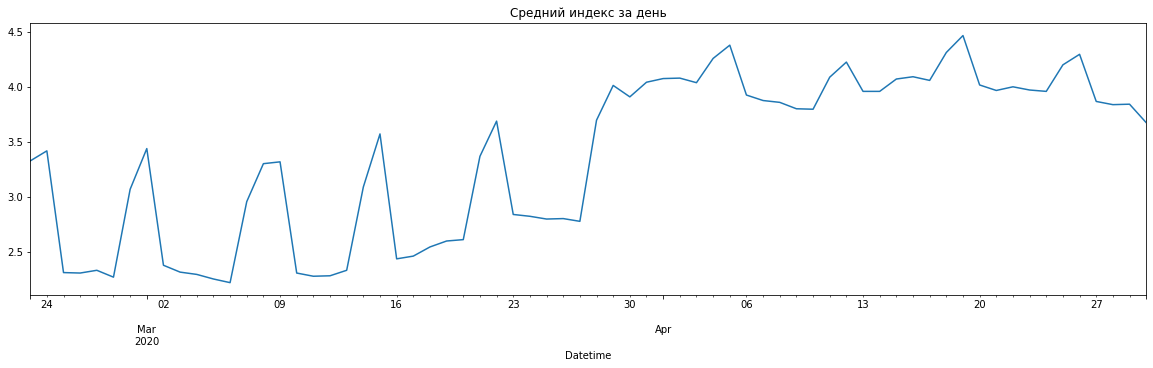

In [11]:
df.Index.resample('d').mean().plot(figsize=(20,5), title='Средний индекс за день')
plt.show()

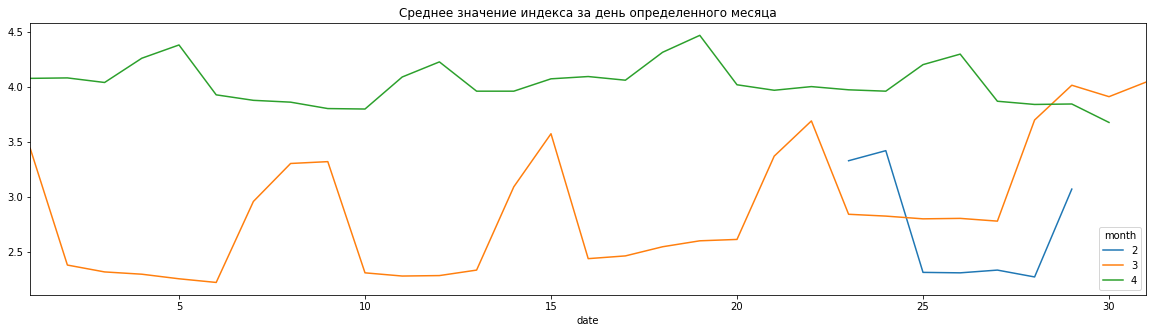

In [12]:
df_date = pd.pivot_table(df, values="Index", columns="month", index="date")
df_date.plot(figsize=(20,5), title='Среднее значение индекса за день определенного месяца')
plt.show()

In [13]:
df.loc['2020-02-24','weekend'], df.loc['2020-03-9','weekend'] = 1, 1

**Подробнее рассмотрим периуд до карантина, во время и после ужесточения**

**Ниже представленны графики для различных этапов карантина, а также отдельно для будних и выходных дней усредненные по соответствующим дням**

**По прежнему видно, что после введения карантина индекс самоизоляции заметно вырос, также видно, что на выходных наш показатель в среднем выше и наглядно показано в какие часы индекс имеет меньшее значение**

**Интуитивно кажется, что после ужесточения карантина индекс самоизоляции должен увеличится, но на графиках заметных перемен не наблюдается**

In [14]:
df_weekend = df[df['weekend'] == 1]
df_not_weekend = df[df['weekend'] == 0]

def list_of_day(mass):
    return [ np.mean(mass[i::24]) for i in range(24) ]

In [15]:
l00 = df_not_weekend[df_not_weekend['quarantine'] == 0]['Index'].tolist()
l10 = df_not_weekend[df_not_weekend['quarantine'] == 1]['Index'].tolist()
l20 = df_not_weekend[df_not_weekend['quarantine'] == 2]['Index'].tolist()

l01 = df_weekend[df_weekend['quarantine'] == 0]['Index'].tolist()
l11 = df_weekend[df_weekend['quarantine'] == 1]['Index'].tolist()
l21 = df_weekend[df_weekend['quarantine'] == 2]['Index'].tolist()

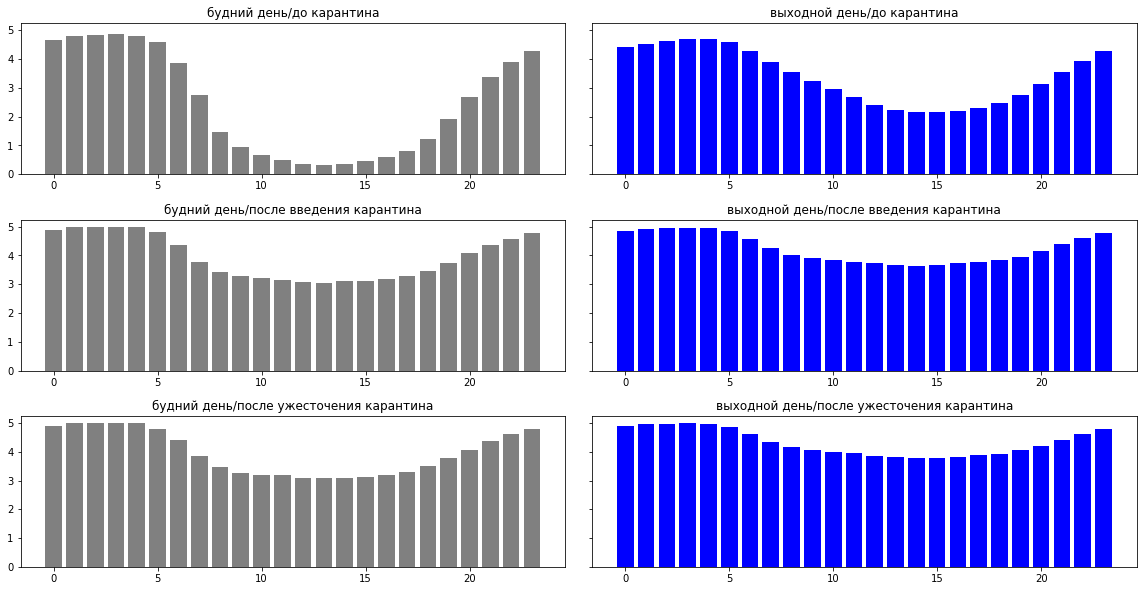

In [16]:
fig, axes = plt.subplots(3, 2, sharex=False, sharey=True)
fig.set_figheight(10)
fig.set_figwidth(20)

axes[0,0].bar(range(24), list_of_day(l00), color='gray')
axes[1,0].bar(range(24), list_of_day(l10), color='gray')
axes[2,0].bar(range(24), list_of_day(l20), color='gray')

axes[0,1].bar(range(24), list_of_day(l01), color='blue')
axes[1,1].bar(range(24), list_of_day(l11), color='blue')
axes[2,1].bar(range(24), list_of_day(l21), color='blue')

axes[0,0].set_title('будний день/до карантина')
axes[1,0].set_title('будний день/после введения карантина')
axes[2,0].set_title('будний день/после ужесточения карантина')
axes[0,1].set_title('выходной день/до карантина')
axes[1,1].set_title('выходной день/после введения карантина')
axes[2,1].set_title('выходной день/после ужесточения карантина')

plt.subplots_adjust(wspace=0.05, hspace=0.3) 

**Действительно, визуализировав средний индекс по часам для соответствующих этапов самоизоляции можно почти точно сказать, что после введения пропусков индекс не поменялся**

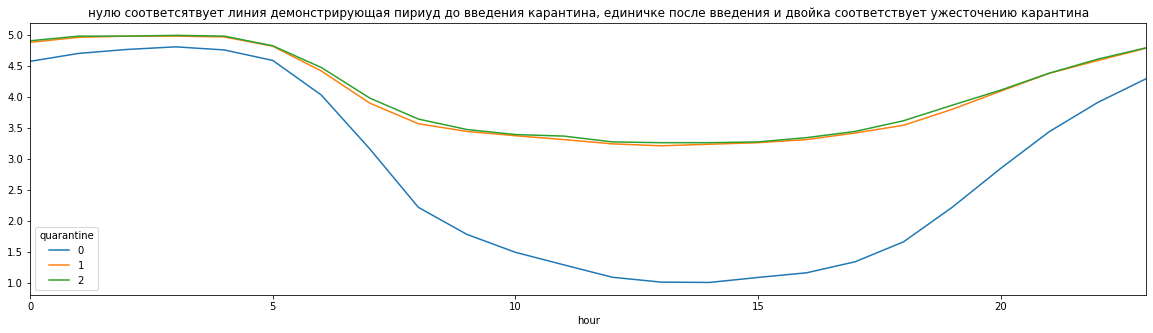

In [17]:
hour_in_quarantine = pd.pivot_table(df, values='Index', columns='quarantine', index='hour')
hour_in_quarantine.plot(figsize=(20,5), title='нулю соответсятвует линия демонстрирующая пириуд до введения карантина, единичке после введения и двойка соответствует ужесточению карантина')
plt.show()

**На следующем графике также покажем разницу индексов после введеня карантина и его ужесточения**

**Тут я взял первые две недели после ужесточения карантина и две недели карантина (дни недели синхронизованы)**

**По оси $OX$ номер часа, где $0$ - номер часа с которого мы начинаем производить сравнение и всего $24 \cdot 14$ часов, по оси $OY$ значение индекса**

**Видно, что кривые почти совпадают, т.е. еще больше убеждаемся в том, что после введение пропускного режима индекс самоизоляции не поменялся**

[]

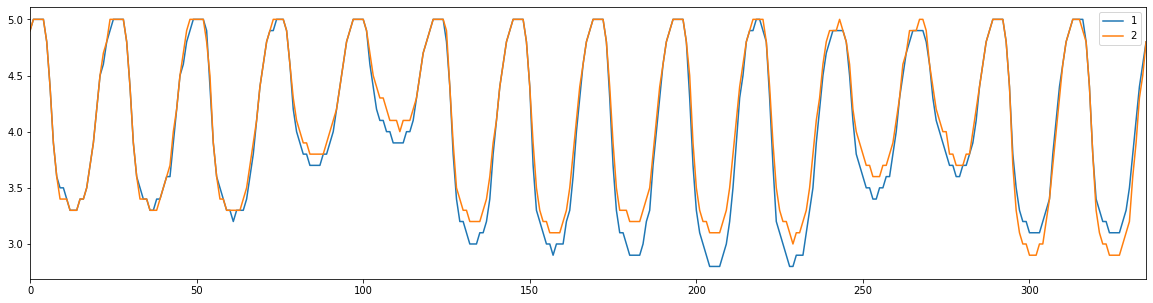

In [18]:
hours_quarantines = pd.DataFrame({ 
    0: df[df.quarantine == 0]['2020-02-26':].Index.tolist()[:336],
    1: df[df.quarantine == 1]['2020-04-01':].Index.tolist()[:336],
    2: df[df.quarantine == 2].Index.tolist()[:336]
})

hours_quarantines[[1,2]].plot(figsize=(20,5))
plt.plot()

### Проверка статистических гипотез 
**Установим уровень значимости 5%**

In [19]:
l0 = np.array(hour_in_quarantine[0])
l1 = np.array(hour_in_quarantine[1])
l2 = np.array(hour_in_quarantine[2])

mass = (l1+l2)/2 - l0

[]

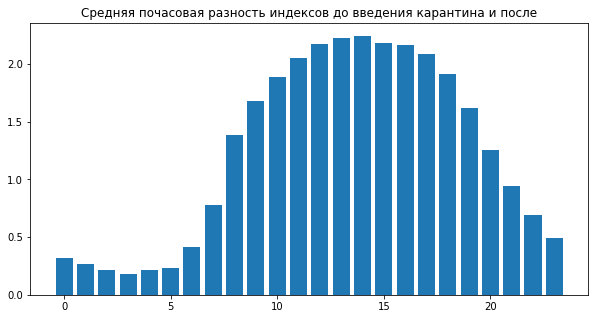

In [20]:
fig, axes = plt.subplots(figsize=(10, 5))
axes.bar(range(24), mass)
plt.title('Средняя почасовая разность индексов до введения карантина и после')
plt.plot()

**Проверим распределение почасовой разности индексов до карантина и после его введения на нормальность, для этого будем использовать Q-Q график и критерий Шапиро-Уилка**


**Если нулевая гипотеза подтвердится, то воспользуемся критерием Стьюдента для связанных выборок**

$H_0\colon$ попарные разности распределены нормально

$H_1\colon$ не нормально

[]

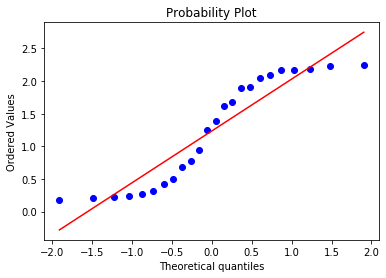

In [21]:
stats.probplot (mass, dist = "norm", plot = plt)
plt.plot()

In [22]:
stats.shapiro(mass)

(0.8544111251831055, 0.0026425274554640055)

**Вероятность ошибочно отвергнуть верную нулевую гипотезу 0.3%, Q-Q график также говорит нам о ненормальности разности распределений**

**Воспользуемся двувыборочным критерием для связанных выборок, чтобы убедиться в том, что после введения карантина индекс вырос**

$ H0_: P(X_1 > X_0) = \frac{1} {2}$

$ H1_: P(X_1 > X_0) \ne \frac{1} {2}$

In [23]:
sign_test (hour_in_quarantine[0] - hour_in_quarantine[1])

(-12.0, 1.1920928955078124e-07)

In [24]:
sign_test (hours_quarantines[0] - hours_quarantines[1])

(-165.5, 1.6082118342191966e-96)

**Действительно, как и ожидалось получили, что индекс изменился после введения карантина**

**Воспользуемся двувыборочным критерием со связанными выборками, чтобы понять изменился ли индекс после ужесточения карантина**

$H_0: med(X_1 - X_2) = 0 $ 

$H_1: med(X_1 - X_2) \ne 0 $ 

In [25]:
stats.wilcoxon (hour_in_quarantine[1], hour_in_quarantine[2])

WilcoxonResult(statistic=0.0, pvalue=2.6929243565254072e-05)

In [26]:
stats.wilcoxon (hours_quarantines[1], hours_quarantines[2])

WilcoxonResult(statistic=3668.5, pvalue=3.131497596262859e-13)

**Мы получили статистисчески значимую разницу индексов**

**Но возьмем во внимание то, что мы используем ранговые критерии. Для периода после ужесточения карантика индекс, действительно выше, но кажется, что разница не значительна**

**Визуализируем эту разницу**

In [27]:
hypotheses =  pd.DataFrame({ 
    'difference': hours_quarantines[2] - hours_quarantines[1],
    '5%': hours_quarantines[2] * 0.05 * np.sign (hours_quarantines[2] - hours_quarantines[1])
})

[]

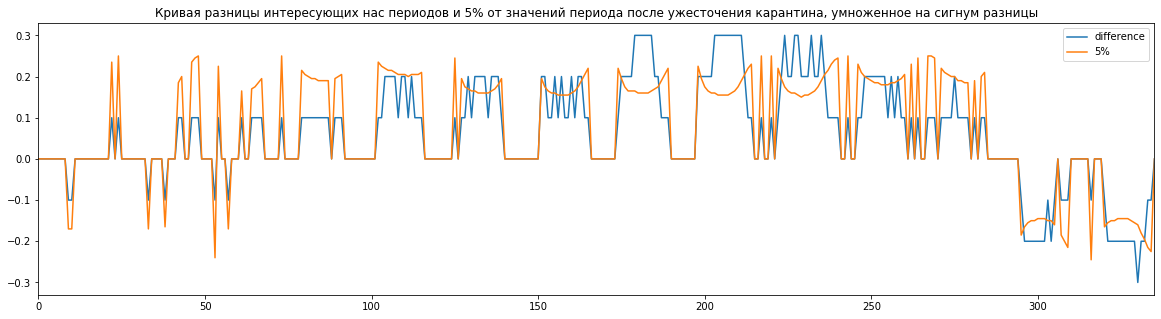

In [28]:
hypotheses.plot(figsize=(20,5))
plt.title('Кривая разницы интересующих нас периодов и 5% от значений периода ' + \
          'после ужесточения карантина, умноженное на сигнум разницы')
plt.plot()

**Видим, что разница может выходить за предел в 5%, значит она и вправду существена**

**Получили, что после введения пропускного режима можно наблюдать различия индексов**

**Теперь с помощью все того же критерия проверим гипотезу наблюдаемую на визуализации о том, что в воскресенье индекс выше, чем в субботу**

$ H_0: индексы\ в\ субботу\ и\ в\ воскресенье\ равны $ 
    
$ H_1: индексы\ отличаются $

In [29]:
m = min(df[df.day_of_week == 5].shape[0], df[df.day_of_week == 6].shape[0])
stats.wilcoxon (df[df.day_of_week == 5][:m].Index, df[df.day_of_week == 6][:m].Index)

WilcoxonResult(statistic=4063.5, pvalue=1.0398688588980934e-10)

**Нулевая гипотеза опровергнута. Получаем, что в последний день недели индекс выше чем в субботу**

### Предсказание временного ряда

**Очевидно, что сезонность временного ряда равна 24 часа**

In [30]:
import statsmodels.api as sm
from pylab import rcParams

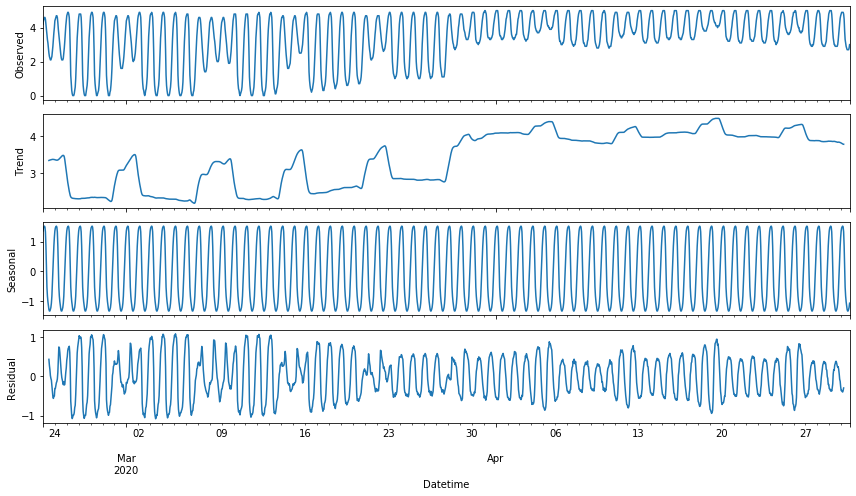

In [31]:
rcParams['figure.figsize'] = 12, 7
result = sm.tsa.seasonal_decompose(df.Index, model='additive',freq= 24)
result.plot()
plt.show()

**В качестве метрик оценок моделей будем использовать $RMSE$ и более интерпретуруюмую метрику $mean \_ absolute \_ percentage \_ error$, равную среднему проценту ошибки по всем часам**

In [32]:
def rmse(y_actual, y_predicted):
    rmse = sqrt(mean_squared_error(y_actual, y_predicted))
    return rmse

def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

##### baseline

**Используем тройное экспоненциальное сглаживание**

In [33]:
from statsmodels.tsa.api import ExponentialSmoothing
from sklearn.metrics import mean_squared_error
from math import sqrt

In [34]:
days = 7
train = df.Index[:-24*days]
test = df.Index[-24*days:]

In [35]:
fit = ExponentialSmoothing(np.asarray(train), seasonal_periods=24, trend=None, seasonal='add').fit()
predict = pd.Series(fit.forecast(test.shape[0]))
predict.index = test.index

/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/holtwinters.py:712: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)


In [36]:
def result(y_test, predict):
    print('RMSE - ', rmse(y_test, predict))
    print('MAPE - ', mean_absolute_percentage_error(y_test,  predict))

result(test, predict)

RMSE -  0.3969076464971273
MAPE -  9.093735330254892


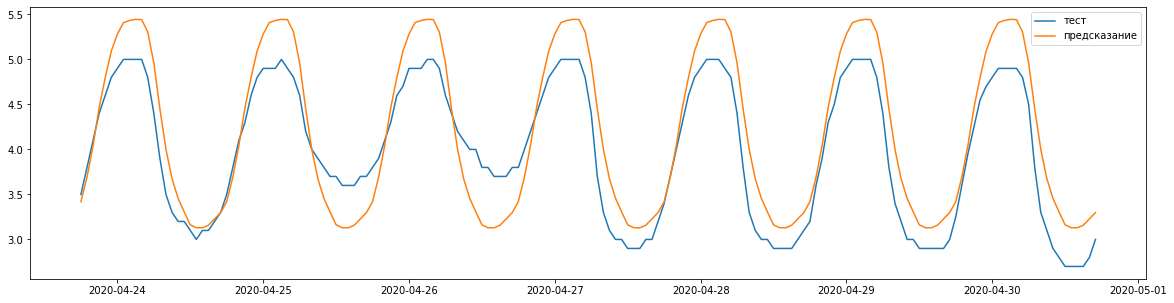

In [37]:
def answer_chart(y_test, predict):
    plt.figure(figsize=(20,5))
    plt.plot(y_test, label='тест')
    plt.plot(predict, label='предсказание')
    plt.legend()
    plt.show()
    
answer_chart(test, predict)

**Мы получили не плохое предсказание, но наша модель не учитывает выходные дни**

**Действительно, наш ряд имеет постоянное матожидание(не учитываю резкий скачек после введения карантина), ковариационная функции не зависит от времени, но он не обладает постоянной дисперсией, что не учитывается в нашем предсказании**

**Применим линейную регрессию для предсказания временного ряда на последние сутки**

In [38]:
from sklearn.linear_model import LinearRegression

In [39]:
data = pd.DataFrame()
data['Index'] = df.Index
data['month'] = df.month.astype('category')
data['date'] = df.date.astype('category')
data['hour'] = df.hour.astype('category')
data['day_of_week'] = df.day_of_week.astype('category')
data['weekend'] = df.weekend.astype('category')
data['quarantine'] = df.quarantine.astype('category')
data.index = range(data.shape[0])

In [40]:
mean = df.groupby(by='hour')['Index'].mean()
data['mean'] = 0
for i in range(24):
    index = data[data.hour == i].index
    data.loc[index, 'mean'] = mean[i]

In [41]:
lag_period = 24
features = []
for period_mult in range(1,10):
    data["lag_period_{}".format(period_mult)] = data.Index.shift(period_mult*lag_period)
    features.append("lag_period_{}".format(period_mult))

data['lagf_mean'] = data[features].mean(axis = 1)

In [42]:
print(data.shape)
data.tail(3)

(1626, 18)


,Index,month,date,hour,day_of_week,weekend,quarantine,mean,lag_period_1,lag_period_2,lag_period_3,lag_period_4,lag_period_5,lag_period_6,lag_period_7,lag_period_8,lag_period_9,lagf_mean
1623,2.7,4,30,15,3,0,2,2.114706,2.9,2.9,3.0,3.7,3.6,3.1,3.1,3.2,3.1,3.177778
1624,2.8,4,30,16,3,0,2,2.182353,2.9,3.0,3.0,3.7,3.7,3.2,3.2,3.3,3.2,3.244444
1625,3.0,4,30,17,3,0,2,2.325000,3.0,3.1,3.2,3.8,3.7,3.3,3.3,3.4,3.3,3.344444


In [43]:
def validation(day, data):
    data.dropna(inplace=True)
    X_train = data.drop('Index', axis = 1)[:-24*day]
    y_train = data.Index[:-24*day]

    X_test = data.drop('Index', axis = 1)[-24*day:]
    y_test = data.Index[-24*day:].values
    return X_train, y_train, X_test, y_test

In [44]:
X_train, y_train, X_test, y_test = validation(1, data)

In [45]:
model = LinearRegression()
model.fit(X_train, y_train)
predict = model.predict(X_test)

In [46]:
result(y_test, predict)

RMSE -  0.10682301964293835
MAPE -  2.628841471736347


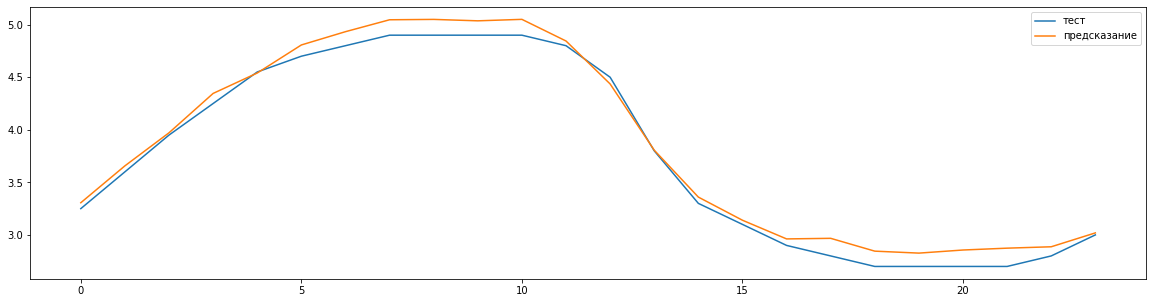

In [47]:
answer_chart(y_test, predict)

**Мы получили хороший результат предсказания индекса на сутки**

**Теперь применим алгоритм случайного леса, чтобы сделать предсказание на неделю**

In [48]:
from sklearn.ensemble import RandomForestRegressor

In [49]:
data = data[['Index', 'month', 'date', 'hour', 'day_of_week', 'quarantine']]
X_train, y_train, X_test, y_test = validation(7, data)

In [50]:
forest = RandomForestRegressor(random_state=123)
forest.fit(X_train, y_train)

/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=10,
                      n_jobs=None, oob_score=False, random_state=123, verbose=0,
                      warm_start=False)

In [51]:
predict = forest.predict(X_test)

In [52]:
result(y_test, predict)

RMSE -  0.18358208232935197
MAPE -  3.9994106058911174


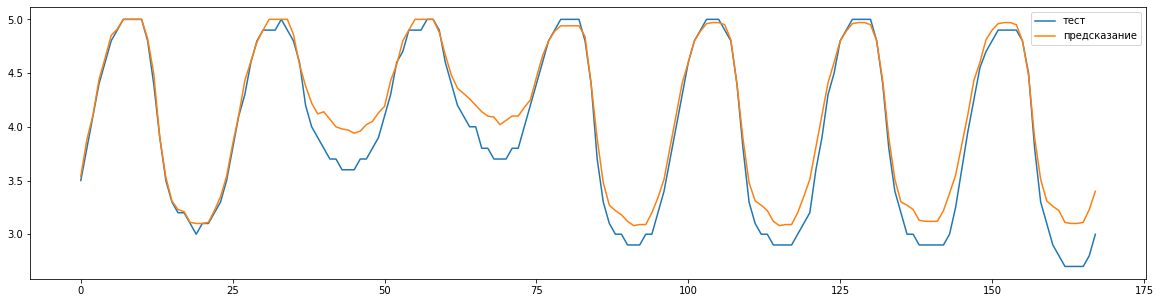

In [53]:
answer_chart(y_test, predict)

**Мы смогли улучшить наш итак очень сильный baseline тройного экспоненциального сглаживания более чем на $50\%$ по метрике $𝑅𝑀𝑆𝐸$**

**Теперь применим рекуррентную нейронную сеть $(LSTM)$**

In [54]:
data = data[data.quarantine == 2]
data.drop(['quarantine'], axis=1, inplace=True)
data.head(3)

,Index,month,date,hour,day_of_week
1248,4.9,4,15,0,2
1249,5.0,4,15,1,2
1250,5.0,4,15,2,2


In [55]:
from sklearn.preprocessing import StandardScaler
from torch.utils.data import DataLoader, Dataset, TensorDataset
import torch
from torch import nn
import plotly
import plotly.graph_objs as go
from IPython.display import clear_output

In [56]:
data = data.values
data = data.astype('float64')
scaler = StandardScaler()
norm_data = scaler.fit_transform(data)

In [57]:
day = 7
test_size = 24 * day
data_train, data_test = norm_data[:-test_size], norm_data[-test_size:]
print(len(data_train), len(data_test))

210 168


In [58]:
def create_dataset(dataset, train_window=7*24, predict_window=24):
    X_data, Y_data = [], []
    for i in range(len(dataset)-train_window-predict_window):
        X_data.append(dataset[i: (i + train_window)])
        Y_data.append(dataset[i + train_window: (i + train_window + predict_window), 0])

    return np.array(X_data), np.array(Y_data)

In [59]:
train_window = 24
predict_window = 4
X_train, Y_train = create_dataset(data_train, train_window, predict_window)
X_test, Y_test = create_dataset(data_test, train_window, predict_window)

In [60]:
train_dataset = TensorDataset(torch.FloatTensor(X_train), torch.FloatTensor(Y_train))
train_dataloader =  DataLoader(train_dataset, batch_size=5, shuffle=False)

test_dataset = TensorDataset(torch.FloatTensor(X_test), torch.FloatTensor(Y_test))
test_dataloader =  DataLoader(test_dataset)

In [61]:
class LSTM(nn.Module):
    def __init__(self, input_size=1, hidden_layer_size=128, output_size=1, num_layers=1):
        super().__init__()
        self.hidden_layer_size = hidden_layer_size

        self.num_layers = num_layers

        self.lstm = nn.LSTM(input_size, hidden_layer_size, num_layers)

        self.linear = nn.Linear(hidden_layer_size, output_size)
        
        self.output_size = output_size

    def forward(self, input_seq):
        lstm_out, self.hidden_cell = self.lstm(input_seq, self.hidden_cell)
        out = lstm_out[-1]
        predictions = self.linear(out)
        
        return predictions.view(-1, self.output_size)
    
    
model = LSTM(input_size=5, output_size=predict_window)

In [62]:
def train(epochs=10, lerning_rate=0.001):
    loss_function = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lerning_rate)
    train_loss, test_loss = list(), list()
    try:
        for epoch in range(1, epochs+1):
            epochs_loss = list()
            for seq, labels in train_dataloader:
                seq = torch.transpose(seq, 0, 1)
                
                optimizer.zero_grad()

                model.hidden_cell = (torch.zeros(model.num_layers, seq.size(1), model.hidden_layer_size),
                                     torch.zeros(model.num_layers, seq.size(1), model.hidden_layer_size))
                
                y_pred = model(seq)
                single_loss = loss_function(y_pred, labels)
                single_loss.backward()
                optimizer.step()

                epochs_loss.append(single_loss.item())
               
            train_loss.append(np.mean(epochs_loss))
            epochs_loss = list()
            for seq, labels in test_dataloader:
                seq = torch.transpose(seq, 0, 1)

                model.hidden_cell = (torch.zeros(model.num_layers, seq.size(1), model.hidden_layer_size),
                                     torch.zeros(model.num_layers, seq.size(1), model.hidden_layer_size))

                y_pred = model(seq)
                single_loss = loss_function(y_pred, labels)

                epochs_loss.append(single_loss.item())

            test_loss.append(np.mean(epochs_loss))
            clear_output(True)
            fig = go.Figure()
            fig.add_trace(go.Scatter(x=[x for x in range(1, epoch+1)], y=train_loss,  name='Train'))
            fig.add_trace(go.Scatter(x=[x for x in range(1, epoch+1)], y=test_loss,  name='Test'))
            fig.update_layout(legend_orientation="h",
                              legend=dict(x=0., xanchor="left"),
                              hovermode="x",
                              title='\rEpoch {0}... Train loss: {1:.4f}'.format(
                              epoch, train_loss[-1]),
                              xaxis_title="Iter",
                              yaxis_title="Loss",
                              margin=dict(l=0, r=0, t=30, b=0))
            fig.update_traces(hoverinfo="all", hovertemplate="Loss: %{y}")
            fig.show()

    except KeyboardInterrupt:
        pass

In [63]:
train(epochs=50)

In [64]:
test_inputs = torch.FloatTensor(norm_data[-test_size -train_window:])
model.eval()

for i in range(0, data_test.shape[0], predict_window):
    seq = test_inputs[i: i+train_window]

    with torch.no_grad():
        model.hidden = (torch.zeros(model.num_layers, 1, model.hidden_layer_size),
                        torch.zeros(model.num_layers, 1, model.hidden_layer_size))
        
        predict = model(seq.view(seq.size(0), 1, seq.size(1))).tolist()
        test_inputs[train_window + i: train_window + i + predict_window, 0] = torch.Tensor(*predict)
        
prediction = scaler.inverse_transform(np.array(test_inputs[train_window:]))

In [65]:
prediction = prediction[:, 0]
testing = data[-test_size:, 0]

result(testing, prediction)

RMSE -  0.13171178147300955
MAPE -  3.0390999067658835


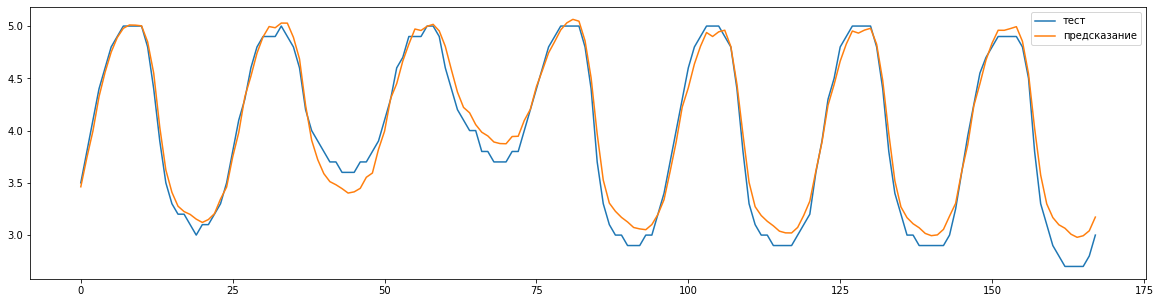

In [66]:
answer_chart(testing, prediction)

**$LSTM$ показал хороший результат, лучше чем случайный лес почти на $30\%$ по метрике $RMSE$**